# Questions Per Language
This notebook intends to show how many stackoverflow questions exist for each programming language that has any considerable measure of use. 

# Step 0: Dependencies
This notebood expects you to already have the major python data science tools like numpy, pandas, and beautifulsoup. The author wrote it using anaconda, and it's recommneded that you use anaconda as well. Odds are if you have jupyter installed, you already have all the necessary tools.

# Step 1: Get a List of Programming Languages
We will use the [wikipedia page "list of programming languages"](https://en.wikipedia.org/wiki/List_of_programming_languages) as our major source. We will begin by downloading the HTML for that page and scraping it for names of programming languages.

In [43]:
WIKIPEDIA_LIST_OF_PROGRAMMING_LANGUAGES = 'https://en.wikipedia.org/wiki/List_of_programming_languages'

import requests
from bs4 import BeautifulSoup

with requests.get(WIKIPEDIA_LIST_OF_PROGRAMMING_LANGUAGES) as r:
    soup = BeautifulSoup(r.text, 'html.parser')

Once we have the data, we can scrape names of programming languages:

In [62]:
import re

content = soup.find('div', {'id': 'mw-content-text'})
sections = content.find_all('div', {'class': 'columns'})

sections_combined = sections[0]
for i in range(1, len(sections)):
    sections_combined.append(sections[i])

# in this case, the following two lines are equivalent:

#lis = sections_combined.findChildren('li')
lis = sections_combined.find_all('li')

# getting just the text and adding it to our list
programming_languages = []
for li in lis:
    programming_languages.append(li.text)
    
# some languages had notes in parenthesis after their names. These were removed.
# notice we also strip the strings here
for i in range(len(programming_languages)):
    programming_languages[i] = re.sub(r'\(.*', '', programming_languages[i]).strip()

print(programming_languages)
# some languages had other extra text and had to be manually edited
programming_languages[programming_languages.index('App Inventor for Android\'s visual block language')] = 'App Inventor'
programming_languages[programming_languages.index('C – ISO/IEC 9899')] = 'C'
programming_languages[programming_languages.index('COBOL – ISO/IEC 1989')] = 'COBOL'
programming_languages[programming_languages.index('CobolScript – COBOL Scripting language')] = 'Cobolscript'
programming_languages[programming_languages.index('EusLisp Robot Programming Language')] = 'EusLisp'
programming_languages[programming_languages.index('Fortran – ISO/IEC 1539')] = 'Fortran'
programming_languages[programming_languages.index('Game Maker Language')] = 'GML'
programming_languages[programming_languages.index('MASM Microsoft Assembly x86')] = 'MASM'
programming_languages[programming_languages.index('MaxScript internal language 3D Studio Max')] = 'maxscript'
programming_languages[programming_languages.index('Nim')] = 'nim-lang'
programming_languages[programming_languages.index('Not eXactly C')] = 'nxc'
programming_languages[programming_languages.index('Object Pascal')] = 'delphi' # stackoverflow calls it delphi and so will we
programming_languages[programming_languages.index('PL/I – ISO 6160')] = 'PL/I'
programming_languages[programming_languages.index('PowerBuilder – 4GL GUI application generator from Sybase')] = 'PowerBuilder'
programming_languages[programming_languages.index('TMG, compiler-compiler')] = 'tmg'
programming_languages[programming_languages.index('WATFIV, WATFOR')] = 'WATFIV'

i = programming_languages.index('AutoLISP / Visual LISP')
programming_languages[i] = 'AutoLISP'
programming_languages.insert(i, 'Visual LISP')

programming_languages.append('.net-core')

### Formatting things so they get properly handled by stackoverflow
# for full rules, see: https://stackoverflow.com/help/tagging

# some languages use the asterix symbol, which is a wildcard on stackoverflow.
# Also, most symbols (like '!' and '@') just get completely removed

# we choose to just remove these languages, as it seems stackoverflow doesn't
# have any questions on them anyways. For instance, the tag 'c-star' has 0 
# questions, and the tag for '@formula' redirects to 'formula', which is the
# tag for any mathematical expression
disallowed_characters = ['*', '!', '@', '$', '′']
for pl in programming_languages:
    for d in disallowed_characters:
        if d in pl:
            print('removing', pl)
            programming_languages.remove(pl) 

# spaces were replaced with '-', as this is the stackoverflow convention
for i in range(len(programming_languages)):
    programming_languages[i] = programming_languages[i].replace(' ', '-')
    
# make lower
for i in range(len(programming_languages)):
    programming_languages[i] = programming_languages[i].lower()

# finally, let's turn our list into a set to remove duplicates
programming_languages = set(programming_languages)

# and (not required) turn it back into a list and alphabetize for convenience
programming_languages = list(programming_languages)
programming_languages = sorted(programming_languages)

# optionally, print and inspect the languages here
print(programming_languages)


['A.NET', 'A-0 System', 'A+', 'ABAP', 'ABC', 'ABC ALGOL', 'ACC', 'Accent', 'Ace DASL', 'Action!', 'ActionScript', 'Actor', 'Ada', 'Adenine', 'AdvPL', 'Agda', 'Agilent VEE', 'Agora', 'AIMMS', 'Aldor', 'Alef', 'ALF', 'ALGOL 58', 'ALGOL 60', 'ALGOL 68', 'ALGOL W', 'Alice', 'Alma-0', 'AmbientTalk', 'Amiga E', 'AMOS', 'AMPL', 'AngelScript', 'Apache Pig latin', 'Apex', 'APL', "App Inventor for Android's visual block language", 'AppleScript', 'APT', 'Arc', 'ARexx', 'Argus', 'Assembly language', 'AutoHotkey', 'AutoIt', 'AutoLISP / Visual LISP', 'Averest', 'AWK', 'Axum', 'B', 'Babbage', 'Ballerina', 'Bash', 'BASIC', 'Batch file', 'bc', 'BCPL', 'BeanShell', 'Bertrand', 'BETA', 'BLISS', 'Blockly', 'BlooP', 'Boo', 'Boomerang', 'Bosque', 'C – ISO/IEC 9899', 'C--', 'C++', 'C*', 'C#', 'C/AL', 'Caché ObjectScript', 'C Shell', 'Caml', 'Cayenne', 'CDuce', 'Cecil', 'Cesil', 'Céu', 'Ceylon', 'CFEngine', 'Cg', 'Ch', 'Chapel', 'Charm', 'CHILL', 'CHIP-8', 'chomski', 'ChucK', 'Cilk', 'CL', 'Claire', 'Clarion'

# Step 2: query serverfault for the number of questions having each tag

In [4]:
#### This cell access the internet ####
# scrapes stackexchange for searches with tags

import signal
import time
from multiprocessing import Pool, Manager, Pipe
from urllib import parse

STACKOVERFLOW_TAG_SEARCH_URL_BASE = 'https://stackoverflow.com/questions/tagged/'

# now in parallel! This doesn't actually speed up the code at all, because our
# bottleneck is stackoverflow. However, this ensures that if one request fails,
# we don't lose all the data we've already obtained. In long lists like this,
# this is important!
NUM_THREADS = 4

# stack exchange states that they throttles all IP addresses sending more than 30 
# requests per second. While writing this notebook, I've been rate limited even
# when sending only 2 requests per second. Therefore, we will wait a generous
# amount of time between each request to avoid rate-limiting

# time is in seconds. This should be equal to or greater than the number of 
# threads (so one request per second) to avoid rate-limiting
TIME_BETWEEN_REQUESTS = 4.0

CODE_ERR_RATE_LIMIT = 429
        
# regular expression for getting number from questions
re_num_questions = re.compile(r'(\d+,?)+' , re.MULTILINE)

def handle_so_tagged_url(pl, result_container, container_lock, pipe, progress, total):
    time.sleep(TIME_BETWEEN_REQUESTS)
    
    # other symbols must be converted to the rfc 2396 escape codes to get properly 
    # handled by stackoverflow. A notable case where this is important is 'c#'
    quoted_pl = parse.quote(pl)
    
    with requests.get(STACKOVERFLOW_TAG_SEARCH_URL_BASE + quoted_pl) as r:
        if r.ok:
            ### create soup from webpage
            stackoverflow_soup = BeautifulSoup(r.text, 'html.parser')

            ### find div with number of questions
            questions_text = stackoverflow_soup.find('div', 
                {'class': 'fs-body3 grid--cell fl1 mr12 sm:mr0 sm:mb12'})
            num_questions_match = re_num_questions.search(questions_text.text)
            num_questions_string = num_questions_match.group(0).replace(',', '')
            num_questions = int(num_questions_string)
            #print(num_questions)

            ### find descripition
            description_container = stackoverflow_soup.find_all('div', {'class': 'mb24'})

            # we are operating under the assumption that the description is the *second* div with 
            # class mb24. THIS MAY CHANGE without notice. We are subject to the whims of 
            # stackexchange
            description_container = description_container[1]
            description = description_container.find('p').text
            description = description.replace('\r\n', ' ')
            description = description.replace('\n', ' ')
            description = description.strip()
            #print(description)

            ### put it all into a tuple that gets added to our list
            container_lock.acquire()
            try:
                result_container.append({
                    'tag': pl,
                    'num_questions': num_questions,
                    'description': description
                })
                print('{:03d}/{:03d}: '.format(progress, total), 
                      'Successfully stored info for questions on tag \'', pl, '\'',
                      sep='')
            finally:
                container_lock.release()
                return (pl, num_questions, description)

        else:
            #print('Got status code ', r.status_code, ' while searching for questions with tag \'',
            #      pl, '\'', sep='')
            if(r.status_code == CODE_ERR_RATE_LIMIT):
                print('This IP address has been rate-limited by stack exchange! Please '
                      + 'try again later. You may optionally increase the time between '
                      + 'requests by editing the variable \'TIME_BETWEEN_REQUESTS\'')
                pipe.send(CODE_ERR_RATE_LIMIT)
    return None

result_codes = []
pl_manager = Manager()
pl_stats_lock = pl_manager.Lock()
pl_stats = pl_manager.list()
pl_pipe_1, pl_pipe_2 = Pipe()

with Pool(processes=NUM_THREADS) as pool:
    
    # the actual work we want to do
    progress = 1
    for pl in programming_languages:
    
    # or, alternatively, some test cases to avoid running eveything
    #for pl in ['c', 'fakelang', 'c++', 'Pro*C', 'c#', 'Pure', 'Pure-Data', 'PureScript', 'Python']:
    
        # do the work, asynchronously
        rc = pool.apply_async(handle_so_tagged_url, 
            (pl, pl_stats, pl_stats_lock, pl_pipe_1, progress, len(programming_languages)) 
        )
        
        # we append a tuple with both the name of the language and the result, so if an
        # exception occurs then we know which language had the problem
        result_codes.append({ 
            'tag': pl, 
            'result': rc
        })
        
        progress+=1
        
    # no more tasks allowed
    pool.close()
    
    # wait for child tasks to finish. This is required, I've tried moving on to the next 
    # cell but the work doesn't get done. I believe the parent process ends at the end
    # of the cell, which would make sense.
    while any(not process['result'].ready() for process in result_codes):
        if pl_pipe_2.poll():
            code = pl_pipe_2.recv()
            if code == CODE_ERR_RATE_LIMIT:
                print('Got code to exit, terminating...')
                pool.terminate()
                break;
        else:
            time.sleep(1)
        


001/672: Successfully stored info for questions on tag '.net-core'
006/672: Successfully stored info for questions on tag 'abap'
007/672: Successfully stored info for questions on tag 'abc'
009/672: Successfully stored info for questions on tag 'acc'
010/672: Successfully stored info for questions on tag 'accent'
012/672: Successfully stored info for questions on tag 'actionscript'
014/672: Successfully stored info for questions on tag 'ada'
013/672: Successfully stored info for questions on tag 'actor'
017/672: Successfully stored info for questions on tag 'agda'
020/672: Successfully stored info for questions on tag 'aimms'
028/672: Successfully stored info for questions on tag 'alice'
032/672: Successfully stored info for questions on tag 'amos'
033/672: Successfully stored info for questions on tag 'ampl'
034/672: Successfully stored info for questions on tag 'angelscript'
036/672: Successfully stored info for questions on tag 'apex'
037/672: Successfully stored info for questions 

## Inspecting the status of each request
If one of these requests has a problem, we should inspect this. Note that it is not strictly necessary to resolve all requests. The language may be malformed (for example, this is the case for 'Pro*C') or may not have any results on stackoverflow.

In [5]:
import traceback

for rc in result_codes:
    # this will not stop when it encounters return code that indicates a problem, which ensures
    # that you won't miss any errors! You may optionally double-check this by uncommenting
    # the line below:
    #print(rc['tag'])
    
    if not rc['result'].successful():
        print('The request corresponding to the language', rc['tag'],
              'had an exception! The error is printed below:')
        try:
            rc['result'].get()
        except Exception as e:
            # capture the exception and print it
            
            # e.__traceback__ seems to include a WHOLE BUNCH more info than we really need...
            #traceback.print_exception(Exception, e, e.__traceback__)     
            
            # this prints, but at the end of all the other prints... I presume it prints to stderr
            #traceback.print_exception(Exception, e, None)
            
            # alternatively to the current solution, print above could have used stderr:
            #print('stuff to print', file=sys.stderr)

            # this seems to do the trick!
            formatted_exception = traceback.format_exception(Exception, e, None)
            # remember that * unpacks a list
            print(*formatted_exception, sep='')
        
        print()

# Step 3: Store data for later use
In case stack exchange decides to implement more aggressive rate-limiting or dramatically changes their website, it will be handy to have this data saved to disk. Since we're going to want to use something like pandas to analyze and visualize the data, it makes sense to just create a DataFrame here and use that to write a csv to disk.

In [6]:
DATA_DIRECTORY = 'data'
DATA_FILENAME = 'plang-data'

import datetime
import pandas
from pathlib import Path

# remember pl_stats is a fancy SyncManager list, so we have to convert it to a normal list
pl_df = pandas.DataFrame(list(pl_stats))

n = datetime.datetime.now();
output_filename = DATA_DIRECTORY + '/' + DATA_FILENAME + '_' + n.strftime('%Y-%m-%d_%H%M') + '.csv'

Path(DATA_DIRECTORY).mkdir(exist_ok=True)

with open(output_filename, 'w') as f:
    pl_df.to_csv(f, index=False)

## Optional: Load old data from CSV
If live data from serverfault isn't available, data may be loaded from a CSV by uncommenting lines 4 and 5 below.

In [1]:
# in case you haven't run cells before this one
import pandas 

try:
    pl_df
except NameError:
    print('pl_df is not defined, loading data from csv')
    with open('data/plang-data_2020-10-19_1722.csv', 'r') as f:
        pl_df = pandas.read_csv(f, header=0)
else:
    print('pl_df is already defined! Doing nothing to avoid overwriting data...')

pl_df is not defined, loading data from csv


# Step 4: Visualize data
Now the fun part! We get to explore this wealth of data we've obtained. First, let's just set a few things up.

In [2]:
import matplotlib.pyplot as plt

# sorting data
pl_df.sort_values('num_questions', ascending=False, inplace=True)

# font size
plt.rcParams.update({'font.size': 18})

Next, let's display a histogram of the distribution of the number of questions to get some idea of what we're looking at.

In [3]:
# this way we know the range of our data, to have a guess at the 
# number of bins we'll need
pl_df.iloc[0]

tag                                                     javascript
num_questions                                              2106002
description      For questions regarding programming in ECMAScr...
Name: 139, dtype: object

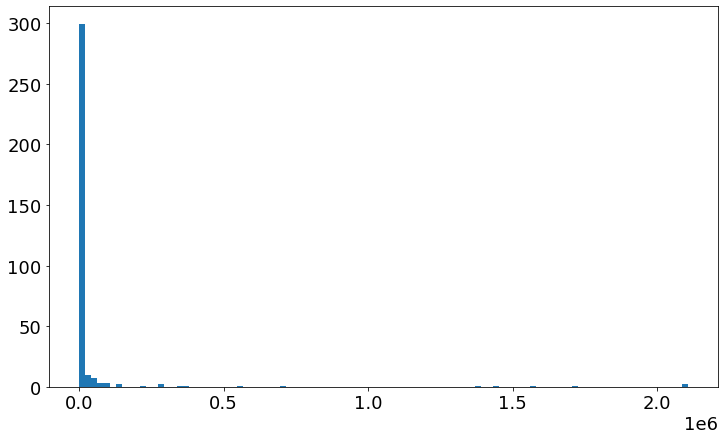

In [4]:
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot()

ax.hist(pl_df['num_questions'], bins=100)

plt.show()

## Top Languages
It's obvious that the vast majority of languages have very few questions on stackoverflow. Instead of trying to visualize everything, let's just visualize the top languages

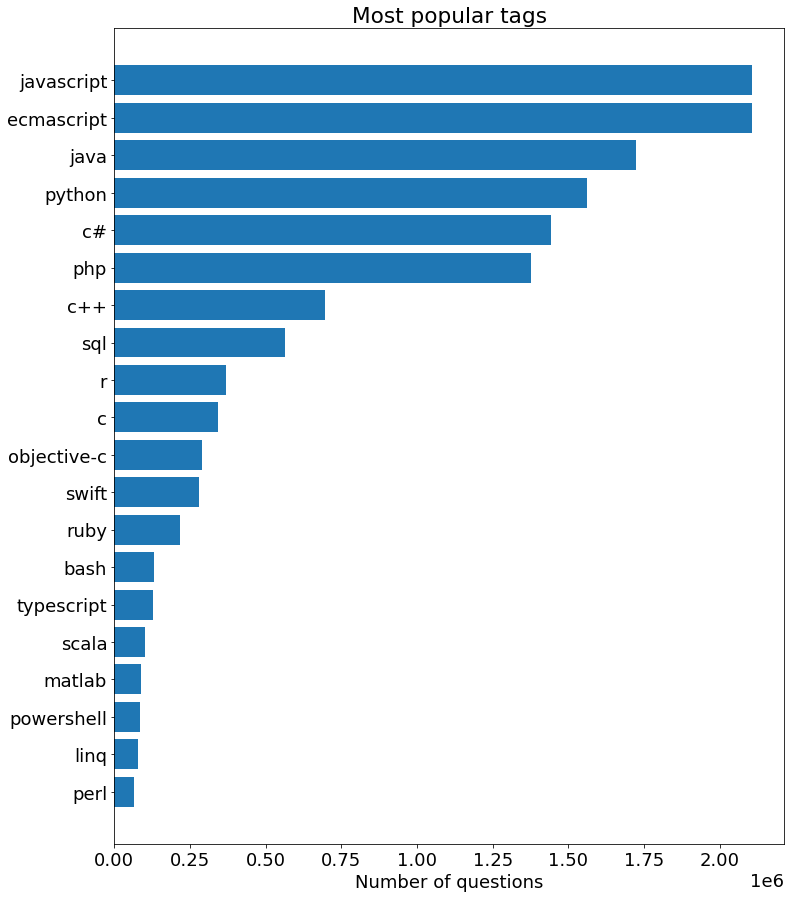

In [8]:
# we chose top 30, this is arbitrary
pl_top_ten = pl_df.iloc[0:20]

fig = plt.figure(figsize=(12, 15))
ax = plt.subplot()

ax.barh(pl_top_ten['tag'], pl_top_ten['num_questions'])

ax.set_xlabel('Number of questions')
ax.set_title('Most popular tags')

ax.invert_yaxis()
#ax.set_xlim([0, 20000])

plt.show()

## Middle-Tier
The most popular languages have more than 2 million questions. This can make tags like 'bash' seem inactive, despite the fact that it has over 100,000 questions!

In [6]:
print(pl_df.iloc[13])

tag                                                           bash
num_questions                                               130087
description      For questions about scripts written for the Ba...
Name: 28, dtype: object


Therefore, let's explore this middle-tier of question frequency.

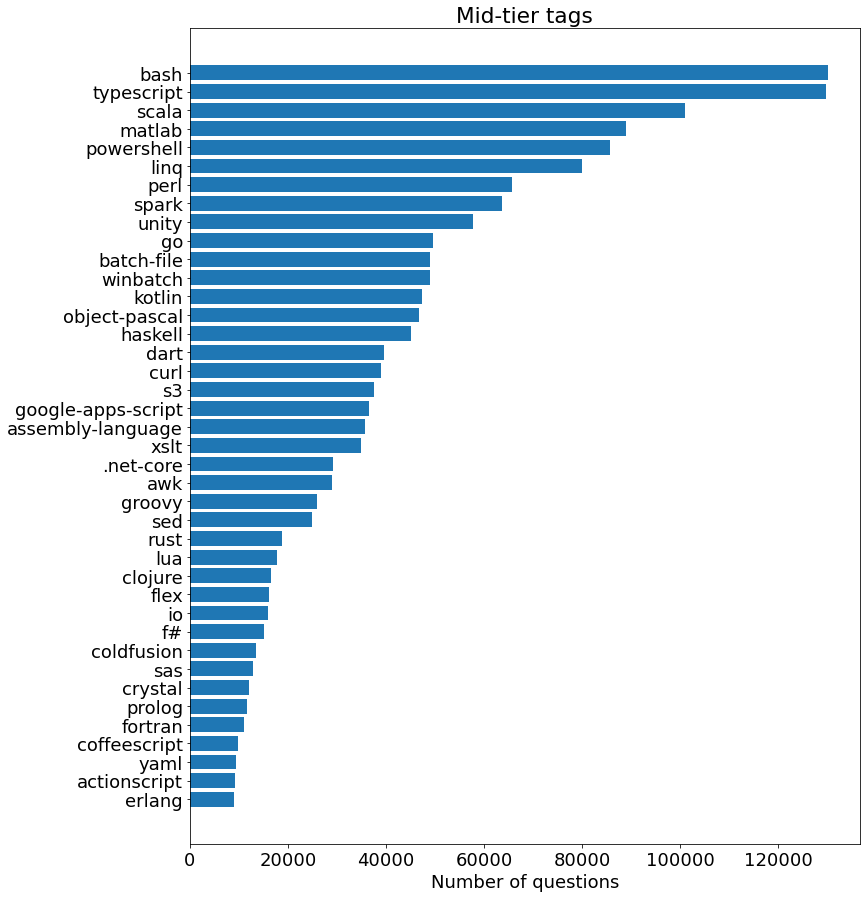

In [9]:
# let's look at the next 40 languages after (and including) bash
pl_middle_tier = pl_df.iloc[13:53]

fig = plt.figure(figsize=(12, 15))
ax = plt.subplot()

ax.barh(pl_middle_tier['tag'], pl_middle_tier['num_questions'])

ax.set_xlabel('Number of questions')
ax.set_title('Middle-tier tags')

ax.invert_yaxis()
#ax.set_xlim([0, 20000])

plt.show()

## Programming languages by category
Categorizing anything is difficult and often arbitrary. However, there are certain classes of languages the author is interested in, and so a few categories have been manually compiled below. Wikipedia has a page titled ["list of programming languages by type"](https://en.wikipedia.org/wiki/List_of_programming_languages_by_type) that was a frequent reference. However, the choice of languages to include was based entirely on the author's interests and opinions.

In any case, let's visualize number of questions per tags within each of these categories. First, we'll gather some interesting categories.

In [55]:
# some specific categories
pl_systems = ['ada', 'c', 'c++', 'd', 'nim', 'rust', 'swift']

pl_functional_pure = ['elm', 'haskell', 'purescript']
pl_functional_impure = ['elixir', 'erlang', 'common-lisp', 'ocaml', 'rust']
pl_functional_all = pl_functional_pure + pl_functional_impure

pl_concurrent = ['ballerina', 'clojure', 'eiffel', 'elixir', 'erlang', 'go']

pl_pure_oo = ['pharo', 'self', 'smalltalk']

# combine everything above without duplicates
pl_authors_interests = set(pl_systems + pl_functional_all + pl_concurrent + pl_pure_oo)

# container for all the above containers
pl_specific_categories = [pl_authors_interests, pl_systems, pl_functional_all,
                          pl_functional_pure, pl_functional_impure, pl_concurrent,
                          pl_pure_oo]

# some broader categories
pl_compiled = ['ada', 'ballerina', 'c', 'c++', 'c#', 'clojure', 'common-lisp', 
               'crystal', 'd', 'delphi', 'eiffel', 'elm', 'erlang', 'f#', 
               'fortran', 'go', 'groovy', 'haskell', 'java', 'julia', 'kotlin',
               'nim', 'objective-c', 'rust', 'scala', 'smalltalk', 'swift', 
               'ocaml']
pl_interpreted = ['javascript', 'lua', 'matlab', 'ocaml', 'php', 'python', 'r', 
                  'ruby', 'bash', ]

# meta-list of all the lists above
categories = [pl_authors_interests, pl_systems, pl_functional_pure, pl_functional_impure,
              pl_functional_all, pl_concurrent, pl_pure_oo, pl_compiled, pl_interpreted]

category_names = ['Author\'s Interests', 'Systems Languages', 'Pure Functional Languages',
                  'Impure Functional Languages', 'All Functional Langauges', 
                  'Concurrent Languages', 'Purely Object Oriented Languages',
                  'Compiled Languages', 'Interpreted Languages']


In [61]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(pl_df.sort_values('tag'))
    print(pl_compiled)
    print(pl_df[pl_df['tag'].isin(pl_compiled)].sort_values('tag'))

['ada', 'ballerina', 'c', 'c++', 'c#', 'clojure', 'common-lisp', 'crystal', 'd', 'delphi', 'eiffel', 'elm', 'erlang', 'f#', 'fortran', 'go', 'groovy', 'haskell', 'java', 'julia', 'kotlin', 'nim', 'objective-c', 'rust', 'scala', 'smalltalk', 'swift', 'ocaml']
             tag  num_questions  \
6            ada           1918   
27     ballerina            260   
40             c         341972   
41            c#        1442296   
42           c++         696344   
58       clojure          16589   
63   common-lisp           5381   
69       crystal          11998   
75             d           2559   
90        eiffel            267   
92           elm           1716   
95        erlang           8951   
96            f#          15133   
105      fortran          10979   
116           go          49509   
120       groovy          25915   
123      haskell          44971   
138         java        1723671   
143        julia           7477   
149       kotlin          47368   
212  o

And then we'll visualize them

WARN: lengths of categories and dataframe do not match for category Author's Interests
category length: 21 dataframe length: 20

WARN: lengths of categories and dataframe do not match for category Systems Languages
category length: 7 dataframe length: 6

WARN: lengths of categories and dataframe do not match for category Compiled Languages
category length: 28 dataframe length: 26



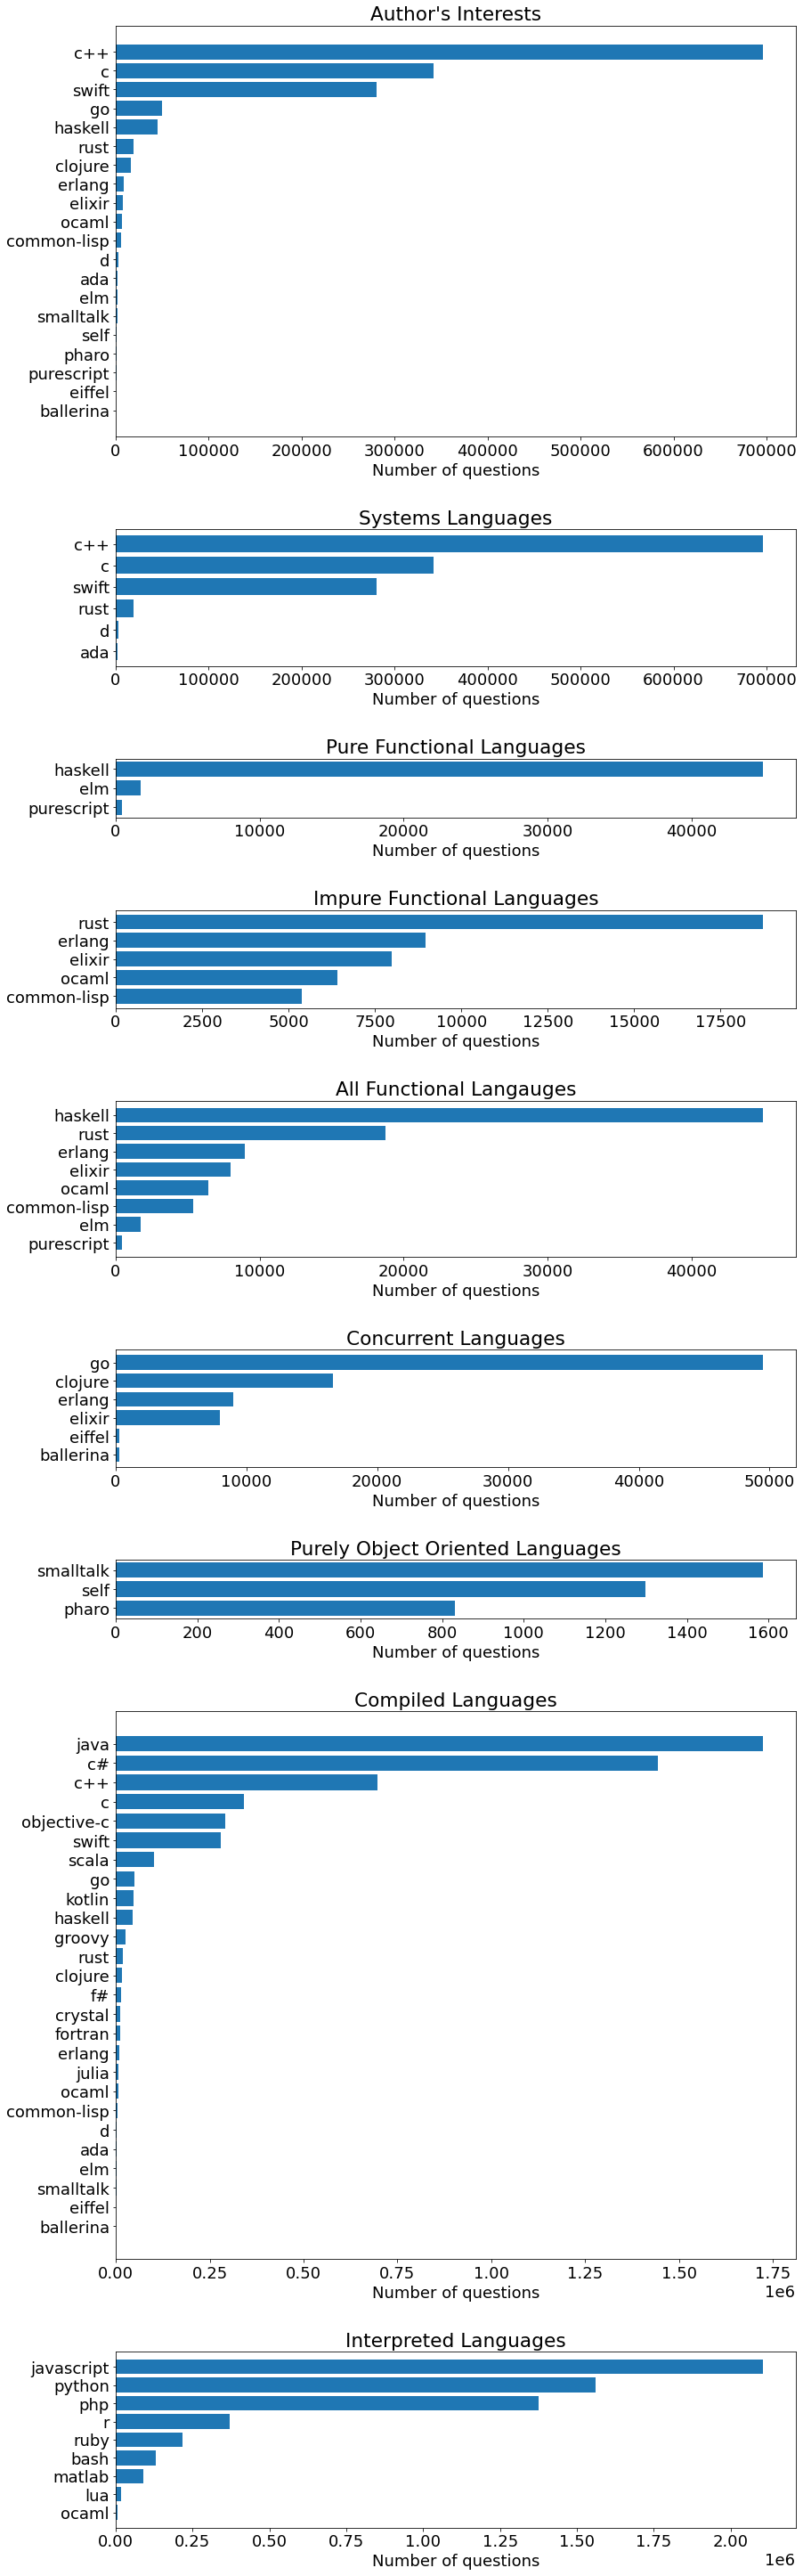

In [59]:
h_ratios = []
for category in categories:
    h_ratios.append(len(category))

# could also do: fig, axs = plt.subplots(9, 1,figsize=(12, 60), gridspec_kw={...})
fig = plt.figure(figsize=(12, 40))
# set height ratios so that bar heights are always the same, but subplots resize
axes = fig.subplots(9, 1, gridspec_kw={'height_ratios': h_ratios})
fig.tight_layout(h_pad=4)

for i in range(len(categories)):
    data = pl_df[pl_df['tag'].isin(categories[i])]
    if(len(categories[i]) != len(data)):
        print('WARN: lengths of categories and dataframe do not match for category', category_names[i])
        print('category length:', len(categories[i]), 'dataframe length:', len(data))
        print()
#         print(categories[i])
#         print(data)
    
    axes[i].barh(data['tag'], data['num_questions'])

    axes[i].set_xlabel('Number of questions')
    axes[i].set_title(category_names[i])

    axes[i].invert_yaxis()
    #axes.set_xlim([0, 20000])

plt.show()

# Conclusion
I believe there is reasonable correlation between popularity of language and number of questions asked: stackoverflow is a huge (and nearly definitive) resource for programmers. Additionally, these results are pretty close to the [most popular technology list](https://insights.stackoverflow.com/survey/2020#most-popular-technologies) on the 2020 stackoverflow survey. However, this is far from a perfect measurement.

One instance of selection bias comes from the kinds of people asking questions on stackoverflow. Most of these people are less experienced or are asking general questions. There is obviously room on stackoverflow for more complex or technical questions, but my experience has shown that most questions are asked by beginner to intermediate programmers. This probably also has to do with the bell curve of experience in any subject: there are simply fewer people with high enough levels of expertise to ask advanced questions.

Additionally, languages with more general usage will also garner more questions. SQL is reported as the 3rd most common technology in the aforementioned survey, but it only has the 8th most questions in our research. This may be because a domain-specific language like SQL is used for fewer things than a general-purpose language like Python.

I wonder if it's possible to also consider how languages that are "harder" will likely have more questions about them. I am sure it would be incredibly difficult to isolate this variable, but it would certainly be fascinating to get some kind of quantitative data about how hard a programming language is.